In [4]:
import numpy as np

def feature_expectations(rewards, gamma):
    discount_factor_timestep = np.power(gamma * np.ones(rewards.shape[1]),
                                        range(rewards.shape[1]))
    discounted_return = discount_factor_timestep[np.newaxis, :, np.newaxis] * rewards
    reward_est_timestep = np.sum(discounted_return, axis=1)
    return reward_est_timestep

class RelativeEntropyIRL(object):
    eps = 1e-24

    def __init__(self,
                 reward_features,
                 reward_random,
                 gamma,
                 horizon,
                 trajectories_expert=None,
                 trajectories_random=None,
                 n_states=None,
                 n_actions=None,
                 learning_rate=0.01,
                 max_iter=100,
                 type_='state',
                 gradient_method='linear',
                 evaluation_horizon=100):

        # transition model: tensor (n_states, n_actions, n_states)

        self.reward_features = reward_features
        self.reward_random = reward_random
        self.trajectories_expert = trajectories_expert
        self.trajectories_random = trajectories_random
        self.gamma = gamma
        self.horizon = horizon
        self.learning_rate = learning_rate
        self.max_iter = max_iter

        if not type_ in ['state', 'state-action']:
            raise ValueError()
        self.type_ = type_

        if not gradient_method in ['linear', 'exponentiated']:
            raise ValueError()
        self.gradient_method = gradient_method

        self.evaluation_horizon = evaluation_horizon

        self.n_states, self.n_actions = n_states, n_actions
        self.n_features = reward_features.shape[2]

    def fit(self, verbose=False):

        #Compute features expectations
        expert_feature_expectations = feature_expectations(self.reward_features, self.gamma)
        random_feature_expectations = feature_expectations(self.reward_random, self.gamma)
        return reirl(expert_feature_expectations, random_feature_expectations, max_iter=self.max_iter,
                     learning_rate=self.learning_rate, verbose=verbose)

        # expert_feature_expectations
        # n_random_trajectories = self.reward_random.shape[0]
        # importance_sampling = np.zeros(n_random_trajectories)
        #
        # #Weights initialization
        # w = np.ones(self.n_features) / self.n_features
        # #Gradient descent
        # for i in range(self.max_iter):
        #     if verbose:
        #         print('Iteration %s/%s' % (i + 1, self.max_iter))
        #
        #     for j in range(n_random_trajectories):
        #         importance_sampling[j] = np.dot(random_feature_expectations[j], w)
        #     importance_sampling -= np.max(importance_sampling)
        #     importance_sampling = np.exp(importance_sampling)/np.sum(np.exp(importance_sampling), axis=0)
        #     weighted_sum = np.sum(
        #         np.multiply(np.array([importance_sampling, ] * random_feature_expectations.shape[1]).T,
        #                     random_feature_expectations), axis=0)
        #
        #     w += self.learning_rate * (expert_feature_expectations_mean - weighted_sum)
        #     # One weird trick to ensure that the weights don't blow up the objective.
        #     w = w / np.linalg.norm(w, keepdims=True)
        # return w


def reirl(expert_feature_expectations, random_feature_expectations, max_iter=100, learning_rate=0.01, verbose=False):
    # Compute features expectations
    expert_feature_expectations_mean = np.mean(expert_feature_expectations, axis=0)

    n_random_trajectories = int(len(random_feature_expectations))
    importance_sampling = np.zeros(n_random_trajectories)

    # Weights initialization
    n_features = expert_feature_expectations_mean.shape[-1]
    w = np.ones(n_features) / n_features

    # Gradient descent
    for i in range(max_iter):

        if verbose:
            print('Iteration %s/%s' % (i + 1, max_iter))

        for j in range(n_random_trajectories):
            importance_sampling[j] = np.exp(np.dot(random_feature_expectations[j], w))
        importance_sampling /= np.sum(importance_sampling, axis=0)
        weighted_sum = np.sum(np.multiply(np.array([importance_sampling, ] * random_feature_expectations.shape[1]).T,
                                          random_feature_expectations), axis=0)

        w += learning_rate * (expert_feature_expectations_mean - weighted_sum)

        # One weird trick to ensure that the weights don't blow up the objective.
        w = w / np.linalg.norm(w, keepdims=True)

    w /= np.linalg.norm(w, ord=1, keepdims=True)
    return w

In [5]:
import numpy as np
from time import sleep
from envs.continuous_gridword import GridWorldAction
from estimators.gradient_descent import Adam
import argparse
from joblib import Parallel, delayed
import pickle
from plot_gridworld import plot_grid


def create_batch_trajectories(env, batch_size, len_trajectories, param, variance, render=False):
    state_dim = np.prod(env.observation_space.shape)
    action_dim = env.action_space.shape[0]

    states = np.zeros((batch_size, len_trajectories, state_dim))
    actions = np.zeros((batch_size, len_trajectories, action_dim))
    rewards = np.zeros((batch_size, len_trajectories))
    mask = np.ones((batch_size, len_trajectories))
    reward_features = np.zeros((batch_size, len_trajectories, 3))

    for batch in range(batch_size):
        state = env.reset(rbf=True)

        if render and batch == 0:
            env._render()
            sleep(0.1)

        for t in range(len_trajectories):
            action = np.random.multivariate_normal(np.dot(param.T, state), np.eye(action_dim) * variance)
            next_state, reward, done, info = env.step(action, rbf=True)

            if render and batch == 0:  # render:
                env._render()
                sleep(0.1)

            # print(state.shape)
            states[batch, t] = state
            actions[batch, t] = action
            rewards[batch, t] = reward
            reward_features[batch, t] = info['features']

            if done:
                states[batch, t + 1:] = state
                actions[batch, t + 1:] = action
                reward_features[batch, t + 1:] = info['features'][:3]
                mask[batch, t + 1:] = 0.
                break

            state = next_state

    return states, actions, rewards, reward_features, mask


def gradient_est(param, batch_size, len_trajectories, states, actions, var_policy):
    gradients = np.zeros((batch_size, len_trajectories, param.shape[0], param.shape[1]))

    for b in range(batch_size):
        for t in range(len_trajectories):
            action = actions[b, t]
            state = states[b, t]
            mean = np.dot(param.T, state)
            gradients[b, t, :, :] = np.outer(action - mean, state).T / var_policy
    return gradients


def policy_gradient_est(param, batch_size, len_trajectories, states, actions, rewards, reward_features, mask, gamma,
                        return_mean=True, return_ravel=False):
    if reward_features is not None:
        rewards = reward_features
    else:
        rewards = rewards[:, :, None]

    discount_factor_timestep = gamma ** np.arange(len_trajectories)
    discounted_reward = discount_factor_timestep[None, :, None] * rewards * mask[:, :, None]  # (N, T, k)

    gradients = gradient_est(param, batch_size, len_trajectories, states, actions, var_policy)  # (N, T, q, d)
    gradient_timestep = np.cumsum(gradients * mask[:, :, None, None], axis=1)  # (N, T, q, d)

    baseline_den = np.mean(gradient_timestep ** 2, axis=0)[:, :, :, None] + 1e-24  # (T, q, d, 1)
    baseline_num = np.mean(gradient_timestep[:, :, :, :, None] ** 2 * discounted_reward[:, :, None, None, :],
                           axis=0)  # (T, q, d, k)
    baseline = baseline_num / baseline_den

    gradient_per_episode = np.sum(gradient_timestep[:, :, :, :, None] * (discounted_reward[:, :, None, None, :]
                                                                         - baseline[None, :, :, :, :]),
                                  axis=1)  # (q, d, k)

    if return_mean:
        gradient = np.mean(gradient_per_episode, axis=0)
        if return_ravel:
            gradient = gradient.reshape(-1, gradient.shape[-1])
    else:
        gradient = gradient_per_episode
        if return_ravel:
            gradient = gradient.reshape(gradient.shape[0], -1, gradient.shape[-1])

    return gradient.squeeze()


def gpomdp(env, num_batch, batch_size, len_trajectories, initial_param, gamma, var_policy, verbose=False, render=False):
    param = np.array(initial_param)
    results = np.zeros(num_batch)

    discount_factor_timestep = gamma ** np.arange(len_trajectories)

    gradient = np.zeros_like(param)
    rewards__ = np.zeros(num_batch)
    gradients__ = np.zeros(num_batch)
    lens__ = np.zeros(num_batch)

    optimizer = Adam(learning_rate=0.05, ascent=True)
    optimizer.initialize(param)

    for i in range(num_batch):
        if i > 0:
            param = optimizer.update(gradient)
            # param += 0.05*gradient
        states, actions, rewards, _, mask = create_batch_trajectories(env, batch_size, len_trajectories, param,
                                                                      var_policy, render=render)

        gradient = policy_gradient_est(param, batch_size, len_trajectories, states, actions, rewards, None, mask, gamma)

        results[i] = np.mean(np.sum(discount_factor_timestep[None, :] * rewards * mask, axis=1), axis=0)

        if verbose:
            gradients__[i] = np.linalg.norm(gradient.ravel())
            rewards__[i] = np.mean(np.sum(rewards, axis=1))
            lens__[i] = np.mean(np.sum(mask, axis=1))
            print('Ite %s - Grad %s - Rewards %s - Lens %s' % (i, gradients__[i], rewards__[i], lens__[i]))

    return param, results, states, rewards__, gradients__


def compute_feature_expectations(len_trajectories, reward_features, mask, gamma):
    discount_factor_timestep = gamma ** np.arange(len_trajectories)
    return np.sum(discount_factor_timestep[None, :, None] * mask[:, :, None] * reward_features, axis=1)


def discretize_actions(actions, action_max, action_min, n_bins_per_dim):
    actions = np.clip(actions, action_min, action_max)
    dims = len(action_max)
    discretized_actions = np.zeros(actions.shape[:2])

    for i in range(dims):
        bins = np.linspace(action_min[i] - 1e-12, action_max[i] + 1e-12, n_bins_per_dim + 1)
        indices = np.digitize(actions[:, :, i].ravel(), bins).reshape(actions[:, :, i].shape) - 1
        assert np.max(indices) <= n_bins_per_dim - 1 and np.min(indices) >= 0
        discretized_actions += indices * n_bins_per_dim ** i
    assert np.min(discretized_actions) >= 0 and np.max(discretized_actions) <= n_bins_per_dim ** dims - 1
    return discretized_actions.astype(int)


def _perform_irl(i, N_traj_irl, n_samples_irl, horizon, fail_prob, save_gradients, param, var_policy, save_path):
    np.random.seed(i)
    res = np.zeros((len(n_samples_irl), 1))
    weights_diff = np.zeros((len(n_samples_irl), 1))
    env = GridWorldAction(shape=shape, rew_weights=rew_weights,
                          randomized_initial=True, horizon=horizon,
                          n_bases=n_basis, fail_prob=fail_prob,
                          border_width=1)

    print("\nIRL Experiment %s" % i)
    print("Collecting Trajectories and Computing Gradients...")

    env_irl = GridWorldAction(shape=shape, rew_weights=[0., 0., 0.],
                              randomized_initial=True, horizon=horizon,
                              n_bases=n_basis, fail_prob=fail_prob,
                              border_width=1)

    states, actions, _, reward_features, mask = create_batch_trajectories(env_irl, batch_size=N_traj_irl,
                                                                          len_trajectories=horizon, param=param,
                                                                          variance=var_policy)

    discretized_actions = discretize_actions(actions, env.action_high, env.action_low, n_bins_per_dim=3)

    estimated_gradients = policy_gradient_est(param, batch_size=N_traj_irl, len_trajectories=horizon,
                                              states=states, actions=actions, rewards=None,
                                              reward_features=reward_features, mask=mask, gamma=gamma,
                                              return_mean=False, return_ravel=True)

    feature_exp = compute_feature_expectations(horizon, reward_features, mask, gamma)

    if save_gradients:
        np.save(save_path + "/gridworld_grads_%s_%s_%s_%s.npy" % tuple(rew_weights + [i]), estimated_gradients)

    # Collect trajectories for REIRL
    _, _, _, reward_features_random, mask = create_batch_trajectories(env_irl, batch_size=N_traj_irl,
                                                                      len_trajectories=horizon,
                                                                      param=np.zeros_like(param),
                                                                      variance=1)

    feature_exp_random = compute_feature_expectations(horizon, reward_features_random, mask, gamma)

    for j, n in enumerate(n_samples_irl):
        print("\n\tIRL Episodes: %s" % n)

        # REIRL
        print("\tSolving REIRL")
        weights_reirl = reirl(feature_exp[:n], feature_exp_random[:n])

        weights_diff[j,0] = np.linalg.norm(weights_reirl - rew_weights)

        if train_after_irl:

            env_train_ = GridWorldAction(shape=shape, rew_weights=weights_reirl,
                                         randomized_initial=True, horizon=horizon,
                                         n_bases=n_basis, fail_prob=fail_prob,
                                         border_width=1)

            params_, _, _, _, _ = gpomdp(env_train_, num_batch=50, batch_size=100, len_trajectories=horizon,
                                         initial_param=np.zeros((np.prod(n_basis), 2)),
                                         gamma=gamma, var_policy=var_policy, verbose=False)

            _, results_, _, _, _ = gpomdp(env, num_batch=1, batch_size=100, len_trajectories=horizon,
                                          initial_param=params_,
                                          gamma=gamma, var_policy=var_policy, verbose=False)

            print("\t\tPerformance %s: %s" % ("REIRL", results_[0]))

            res[j, 0] = results_[0]

    return res, weights_diff, "REILR"

Ite 0 - Grad 27.24258327133451 - Rewards -47.90683168316832 - Lens 81.98
Ite 1 - Grad 9.579038297003978 - Rewards -21.044158415841583 - Lens 60.24
Ite 2 - Grad 10.128501375404614 - Rewards -14.262079207920788 - Lens 61.68
Ite 3 - Grad 3.3975584045836547 - Rewards -12.298217821782178 - Lens 64.03
Ite 4 - Grad 4.447072600406869 - Rewards -11.240594059405941 - Lens 57.9
Ite 5 - Grad 5.46232270480162 - Rewards -12.778415841584156 - Lens 57.84
Ite 6 - Grad 4.037892629568113 - Rewards -11.727623762376236 - Lens 54.56
Ite 7 - Grad 4.090615550315577 - Rewards -11.784950495049502 - Lens 53.21
Ite 8 - Grad 5.574128676104215 - Rewards -13.039900990099008 - Lens 58.26
Ite 9 - Grad 3.5608958446637557 - Rewards -12.144653465346533 - Lens 56.53
Ite 10 - Grad 3.211530749801284 - Rewards -8.177326732673269 - Lens 42.98
Ite 11 - Grad 4.591118289896571 - Rewards -10.277722772277228 - Lens 51.49
Ite 12 - Grad 3.180819967807844 - Rewards -9.536633663366336 - Lens 51.88
Ite 13 - Grad 3.850258191567362 - Rew

IndexError: index 1 is out of bounds for axis 1 with size 1

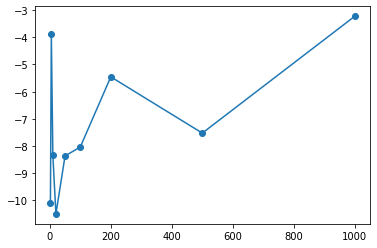

In [6]:
#parser.add_argument('--horizon', type=int, default=100, help='length of the episodes')
#parser.add_argument('--gamma', type=float, default=0.99, help='discount factor')
#parser.add_argument('--var_policy', type=float, default=0.1, help='variance of the policy')
#parser.add_argument('--shape', type=int, nargs='+', default=[], help='shape of gird')
#parser.add_argument('--n_basis', type=int, nargs='+', default=[], help='number of rbf basis for the state '
#                                                                       'representation')
#parser.add_argument('--fail_prob', type=float, default=0.1, help='stochasticity of the environment')
#parser.add_argument('--load_policy', action='store_true', help='load a pretrained policy')
#parser.add_argument('--load_path', type=str, default='data/gridworld_single', help='path to model to load')
#parser.add_argument('--save_policy', action='store_true', help='save the trained policy')
#parser.add_argument('--save_path', type=str, default='data/gridworld_single', help='path to save the model')
#parser.add_argument('--save_gradients', action='store_true', help='save the computed gradients')
#parser.add_argument('--train_after_irl', action='store_true', help='train with the computed rewards')
#parser.add_argument('--n_experiments', type=int, default=10, help='number of experiments to perform')
#parser.add_argument('--n_jobs', type=int, default=1, help='number of parallel jobs')
#parser.add_argument('--render_policy', action='store_true', help='render the interaction with the environment')
#parser.add_argument('--plot_results', action='store_true', help='plot the results')
horizon = 100
gamma =0.99
var_policy=0.1
shape=[5,5]
n_basis=[10,10]
fail_prob=0.1
load_policy=False
save_policy=False
save_path='data/gridworld_single'
train_after_irl=True
n_experiments=1
n_jobs=1
render_policy=True
plot_results=True
save_gradients=False

n_samples_irl = [2, 5, 10, 20, 50, 100, 200, 500, 1000]
N_traj_irl = max(n_samples_irl)

n_experiments = n_experiments
horizon = horizon
gamma = gamma
var_policy = var_policy
fail_prob = fail_prob

load_policy = load_policy
save_policy = save_policy
save_gradients = save_gradients
train_after_irl = train_after_irl

rew_weights = np.array([1., 100., 0.])
rew_weights /= np.sum(rew_weights)
rew_weights = rew_weights.tolist()

res = np.zeros((n_experiments, len(n_samples_irl), 1))
all_weights = np.zeros((n_experiments, len(n_samples_irl), 1))

env = GridWorldAction(shape=shape, rew_weights=rew_weights,
                      randomized_initial=True, horizon=horizon,
                      n_bases=n_basis, fail_prob=fail_prob,
                      border_width=1)

if load_policy:
    print("Loading policy...")
    param = np.load(load_path + "/gridworld_param_%s_%s_%s_fail=%s.npy" % tuple(rew_weights + [fail_prob]))
else:
    # Train expert

    param, _, _, _, _ = gpomdp(env, num_batch=40, batch_size=100, len_trajectories=horizon,
                               initial_param=np.zeros((np.prod(n_basis), 2)),
                               gamma=gamma, var_policy=var_policy, verbose=True)

    if save_policy:
        np.save(save_path + "/gridworld_param_%s_%s_%s_fail=%s.npy" % tuple(rew_weights + [fail_prob]), param)

if render_policy:
    _, _, _, _, _ = gpomdp(env, num_batch=3, batch_size=1, len_trajectories=horizon,
                           initial_param=param,
                           gamma=gamma, var_policy=0., verbose=False, render=True)

_, results, _, _, _ = gpomdp(env, num_batch=1, batch_size=500, len_trajectories=horizon,
                             initial_param=param,
                             gamma=gamma, var_policy=var_policy, verbose=False, render=False)

all_args = N_traj_irl, n_samples_irl, horizon, fail_prob, save_gradients, param, var_policy, save_path
all_results = Parallel(n_jobs=n_jobs, verbose=51)(
    delayed(_perform_irl)(i, *all_args) for i in range(n_experiments))

for i in range(n_experiments):
    res[i], all_weights[i], agents = all_results[i]

np.save(save_path + '/gridworld_res_irl_%s.npy' % fail_prob, res)
np.save(save_path + '/gridworld_res_irl_w_%s.npy' % fail_prob, all_weights)

if plot_results:
    plot_grid(n_samples_irl, res, all_weights, agents, save_path=save_path)

In [9]:
res

array([[[-10.10246641],
        [ -3.89075084],
        [ -8.35083357],
        [-10.51086199],
        [ -8.37387522],
        [ -8.0427985 ],
        [ -5.4576052 ],
        [ -7.53089613],
        [ -3.22268272]]])